In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.random import set_seed

from kaggle_prediction_interval_birthweight.data.data_processing import DataProcessor
from kaggle_prediction_interval_birthweight.workflow.validation import Validator
from kaggle_prediction_interval_birthweight.workflow.histboost_tuning import (
    HistBoostTuner,
)

np.random.seed(1)
set_seed(1)

In [3]:
def plot_result(obs, lower, upper, lower_new, upper_new):
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].vlines(x=obs, ymin=lower, ymax=upper, alpha=0.25)
    ax[0].set_xlim(
        np.min(np.concatenate([obs, lower])), np.max(np.concatenate([obs, upper]))
    )
    ax[0].set_ylim(
        np.min(np.concatenate([obs, lower])), np.max(np.concatenate([obs, upper]))
    )
    ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes, color="orange")
    ax[0].set_xlabel("observations")
    ax[0].set_ylabel("predictions")
    ax[1].hist(lower, bins=100, density=True, color="blue", alpha=0.75, label="train")
    ax[1].hist(
        lower_new, bins=100, density=True, color="orange", alpha=0.75, label="test"
    )
    ax[1].set_xlabel("predicted lower bounds")
    ax[1].legend()
    ax[2].hist(upper, bins=100, density=True, color="blue", alpha=0.75, label="train")
    ax[2].hist(
        upper_new, bins=100, density=True, color="orange", alpha=0.75, label="test"
    )
    ax[2].set_xlabel("predicted upper bounds")
    ax[2].legend()
    plt.show()

In [4]:
data = pd.read_csv("~/dev/data/kaggle-prediction-interval-birthweight/train.csv")
data_test = pd.read_csv("~/dev/data/kaggle-prediction-interval-birthweight/test.csv")

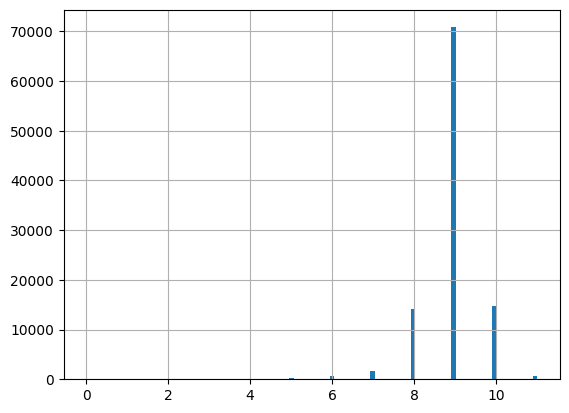

In [8]:
data["gestation_time"] = np.where(
    data["DLMP_MM"] != 99, data["DOB_MM"] - data["DLMP_MM"], np.nan
)
data["gestation_time"] = np.where(
    data["gestation_time"] < 0, data["gestation_time"] + 12, data["gestation_time"]
)
data["gestation_time"].hist(bins=100)
plt.show()

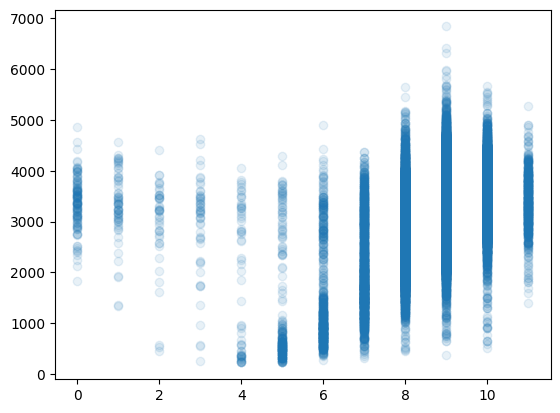

In [9]:
plt.scatter(data["gestation_time"], data["DBWT"], alpha=0.1)
plt.show()

In [5]:
data_processor = DataProcessor("HistBoostRegressor")
X, y = data_processor(data)

In [6]:
tuner = HistBoostTuner(
    verbose=True, categorical_feature_mask=data_processor.categorical_features
)
tuner.tune(X, y)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0001
Function value obtained: -0.1881
Current minimum: -0.1881
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.1630
Function value obtained: -0.1575
Current minimum: -0.1881
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 12.5183
Function value obtained: -0.1655
Current minimum: -0.1881
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 5.0787
Function value obtained: -0.1597
Current minimum: -0.1881
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 6.0487
Function value obtained: -0.1691
Current minimum: -0.1881
Iteration No: 6 started.

In [7]:
-tuner.res_gp.func_vals

array([0.16633246, 0.16091768, 0.13950934, 0.16728207, 0.16694231,
       0.12037622, 0.14593816, 0.05695383, 0.03937143, 0.03761677,
       0.18808337, 0.15751934, 0.16546009, 0.15968668, 0.16905286,
       0.17290193, 0.1764619 , 0.18390476, 0.18279364, 0.17622084,
       0.17318138, 0.1219467 , 0.16939796, 0.18529473, 0.18089733,
       0.18462411, 0.17027441, 0.16414284, 0.12157661, 0.18369461,
       0.15559279, 0.1744973 , 0.17262859, 0.12104075, 0.16758979,
       0.17110757, 0.18483404, 0.17188303, 0.16849078, 0.17861191,
       0.18546259, 0.17178743, 0.17199694, 0.17821552, 0.17622331,
       0.17557217, 0.14085505, 0.07848005, 0.17311205, 0.17465492,
       0.17329843, 0.18486658, 0.16300915, 0.17892909, 0.17987259,
       0.16604272, 0.16761319, 0.14863762, 0.18350647, 0.16794418,
       0.17322063])

In [8]:
tuner.res_gp.x_iters

[[0.9807412289900471, 0.46003068044903095, 2, 50, 31],
 [0.015478974396671025, 0.0008700690210600545, 7, 47, 86],
 [0.008706037847015437, 0.004195085318955972, 5, 15, 58],
 [0.5519326346081447, 0.0019320752621429876, 5, 47, 80],
 [0.140576118573469, 0.10322562466964824, 2, 28, 88],
 [0.9411207450235306, 0.0009091272186646576, 1, 6, 83],
 [0.011314027385678655, 0.12547454048063264, 10, 50, 30],
 [0.0010114989173207183, 0.03800088790514866, 2, 8, 18],
 [0.0010879793134300766, 0.7352148794247115, 1, 43, 99],
 [0.0010045137961386004, 0.0019569974458949688, 1, 49, 79],
 [0.2889736014221303, 1.0, 4, 21, 100],
 [0.5932517736067934, 8.44265904315269, 9, 43, 128],
 [0.3849973255854072, 2.975353090098658, 2, 17, 101],
 [0.8123565600467179, 4.79977692397885, 5, 43, 74],
 [0.6485237001791461, 3.682421715990082, 10, 11, 175],
 [0.4741344372284369, 8.009109510688925, 6, 36, 147],
 [0.5824377722830322, 5.373736920757813, 8, 10, 100],
 [0.18714601098343323, 7.369184402107811, 3, 11, 72],
 [0.150525192

In [9]:
tuner.result

{'score': -0.18808337,
 'opt_parameters': {'learning_rate': 0.2889736014221303,
  'l2_regularization': 1.0,
  'max_depth': 4,
  'max_leaf_nodes': 21,
  'min_samples_leaf': 100}}

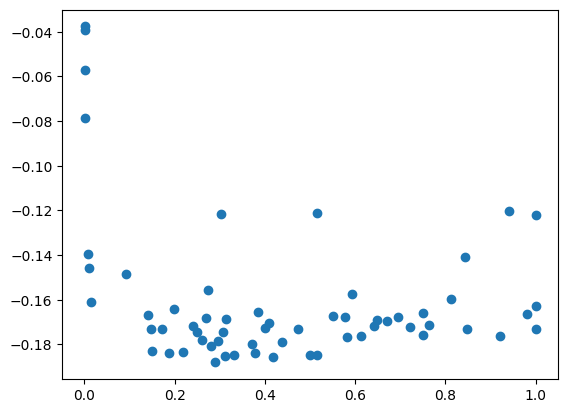

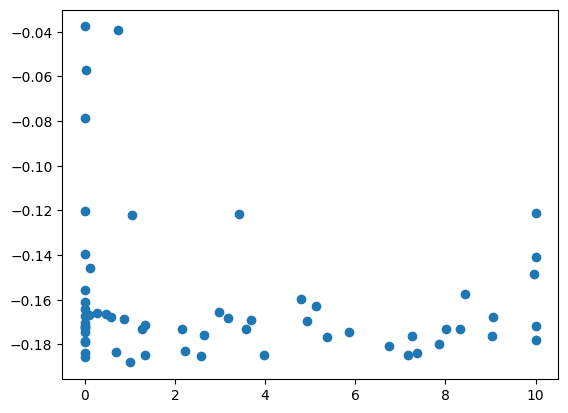

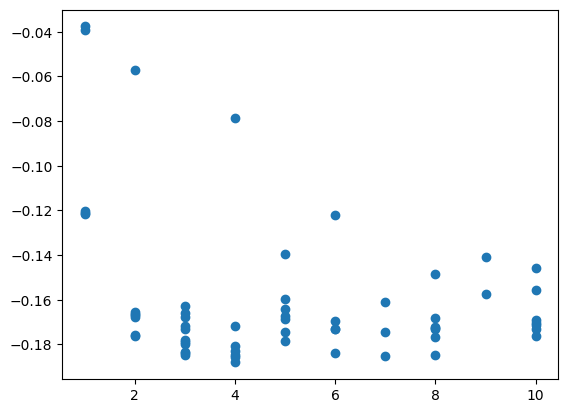

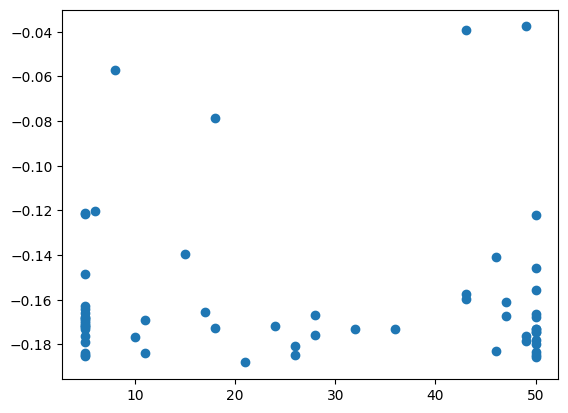

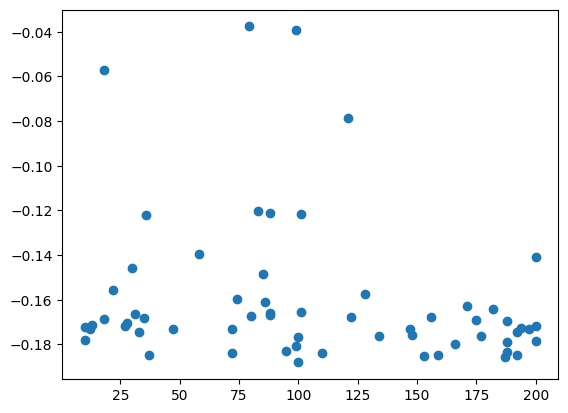

In [10]:
import matplotlib.pyplot as plt

for which_param in range(5):
    x = [i[which_param] for i in tuner.res_gp.x_iters]
    plt.scatter(x, tuner.res_gp.func_vals)
    plt.show()

In [11]:
SAVED_PRIOR_RUNS["x0"][np.array(SAVED_PRIOR_RUNS["y0"]).argmin()]

NameError: name 'SAVED_PRIOR_RUNS' is not defined

In [ ]:
# eim_validator = Validator("HistBoostRegressor")
# eim_validator.fit(data)
# eim_validator.print_performance_summary()

# lower, upper = eim_validator.predict_intervals(data)
# lower_new, upper_new = eim_validator.predict_intervals(data_test)

# plot_result(data["DBWT"], lower, upper, lower_new, upper_new)